In [1]:
import pandas as pd
import math
from math import pi
import numpy as np
from numpy.linalg import inv
import geopy.distance
from matplotlib import pyplot as plt
import seaborn as sns



In [27]:
ipt = pd.read_csv("input.csv")

In [28]:
ipt

,name,lat,lon,band,bcch,eirp,bts
0,136_2,"-8,068361111","-34,892722222",GSM1800,662,"55,59",BTS-1
1,137_3,"-8,075916667","-34,8946111110",GSM1800,806,"55,59",BTS-2
2,197_1,"-8,0763611110","-34,908000000",GSM1800,666,"55,59",BTS-3
3,137_1,"-8,0759166670","-34,894611112",GSM1800,690,"55,59",BTS-4
4,138_2,"-8,0660000000","-34,889444444",GSM1800,673,"55,59",BTS-5
5,245_2,"-8,0645833333","-34,8945833333",GSM1800,682,"55,59",BTS-6


In [29]:
train = pd.read_csv("treino.csv")
train.head()

,pontoId,lat,lon,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6,taBTS1,taBTS2,taBTS3,taBTS4,taBTS5,taBTS6
0,2818,-8.062.787,-34.897.289,131.79,105.09,125.656.666.666.667,105.756.666.666.667,128.49,115.99,1,2,3,2,1,0
1,212,-8.076.408,-34.899.723,120.59,112.123.333.333.333,124.856.666.666.667,132.023.333.333.333,135.523.333.333.333,141.19,2,1,1,1,2,2
2,500,-8.074.771,-34.890.739,118.723.333.333.333,128.556.666.666.667,130.09,989.566.666.666.667,128.59,146.423.333.333.333,1,0,3,0,1,2
3,2094,-806.803,-34.896.683,111.49,109.723.333.333.333,108.056.666.666.667,973.566.666.666.667,118.456.666.666.667,997.233.333.333.333,0,1,2,1,1,0
4,1790,-8.069.077,-34.900.505,123.29,114.34,121.79,126.09,130.09,109.04,1,1,2,1,2,1


### **GET DISTANCE**

In [72]:

def correction_factor_cost(frequency,altura_antena):

    return ((1.1*(np.log10(frequency))-0.7)*altura_antena - (1.56*(np.log10(frequency))-0.8))

def cost231_model(frequency, altura_base, altura_antena, distancia):
    med_loss = (46.3 + 33.9*np.log10(frequency) - 13.82*np.log10(altura_base) \
                - correction_factor_cost(frequency,altura_antena)  + \
                (44.9 - 6.55*np.log10(altura_base))*np.log10(distancia))
    return med_loss
def cost231_model_distance(frequency, altura_base, altura_antena, med_loss):
   a = 46.3 + 33.9*np.log10(frequency) - 13.82*np.log10(altura_base)
   b = correction_factor_cost(frequency,altura_antena)
   c = (44.9 - 6.55*np.log10(altura_base))
   return pow(10.0,(med_loss-a+b)/c)*1000
def freespace_model_distance(frequency, altura_base, altura_antena, med_loss):
    a = 32.44 + 20*np.log10(frequency)
    b = med_loss
    return pow(10.0,(b-a)/20.0)*1000 

In [73]:
def formated(n):
  if isinstance(n,float):
    return n
  n = n.replace('.',',',1).replace('.','').replace(',','.')
  return float(n)

def formated_lat(s):
  if isinstance(s,float):
    return s
  n = 2
  s = s.replace('.','').replace(',','')
  sz = len(s)
  s = float(s)/math.pow(10,sz-n)
  return s
def formated_long(s):
  if isinstance(s,float):
    return s
  n = 3
  s = s.replace('.','').replace(',','')
  sz = len(s)
  s = float(s)/math.pow(10,sz-n)
  return s

 GET MATRIX B

In [74]:
# 2(x0-xn-1) 2(y0-yn-1)
# ...      ...
# 2(xn-2 - xn-1) 2(yn-2 - yn-1)

def get_B(vtx, vty, n):
  B = []
  for i in range(n-1):
    B.append([2*(vtx[i]-vtx[n-1]),2*(vty[i]-vty[n-1])])
  return B


 GET MATRIX C

In [75]:
# x1^2 - xn^2 + y1^2 - yn^2 + dn^2 -d1^2
# ...    
# xn-1^2 - xn^2 + yn-1^2 - yn^2 + dn^2 -dn-1^2

def get_C(vtx, vty, d , n):
  C = []
  for i in range(n-1):
    C.append([vtx[i]*vtx[i] - vtx[n-1]*vtx[n-1] + vty[i]*vty[i] - vty[n-1]*vty[n-1] + d[n-1]*d[n-1] - d[i]*d[i]])
  return C


In [76]:
!pip install pyproj


In [77]:
from pyproj import Proj

ipt['lat'] = ipt['lat'].apply(formated_lat)
ipt['lon'] = ipt['lon'].apply(formated_long)

p = Proj(proj='utm',zone=10,ellps='WGS84', preserve_units=False)
ipt["x"],ipt["y"] = p(ipt['lon'],ipt['lat'])
ipt[["x","y"]]

,x,y
0,1.683501e+07,-8.707782e+06
1,1.682972e+07,-8.707463e+06
2,1.682776e+07,-8.698601e+06
3,1.682972e+07,-8.707463e+06
4,1.683700e+07,-8.709674e+06
5,1.683731e+07,-8.706071e+06


In [78]:
ipt[["lon","lat"]]

,lon,lat
0,-34.892722,-8.068361
1,-34.894611,-8.075917
2,-34.908000,-8.076361
3,-34.894611,-8.075917
4,-34.889444,-8.066000
5,-34.894583,-8.064583


In [80]:
c = 300000000.0 #vel light
f = 1800000000.0 #gsm1800
lbd =  c/f
vt_id = []
vt_lo_mdt1 = []
vt_la_mdt1 = []
vt_lo_mdt2 = []
vt_la_mdt2 = []
for i in range(len(train)):
  lp1 = formated(train["pathBTS1"][i])
  lp2 = formated(train["pathBTS2"][i])
  lp3 = formated(train["pathBTS3"][i])
  lp4 = formated(train["pathBTS4"][i])
  lp5 = formated(train["pathBTS5"][i])
  lp6 = formated(train["pathBTS6"][i])
  #if train["pontoId"][i] == 500:
    #print(lp1,lp2,lp3,lp4,lp5,lp6)
  distance_mtd1 = []
  distance_mtd2 = []
  distance_mtd1.append(cost231_model_distance(frequency=1800, altura_base=100.0, altura_antena=2, med_loss=lp1))
  distance_mtd1.append(cost231_model_distance(frequency=1800, altura_base=100.0, altura_antena=2, med_loss=lp2))
  distance_mtd1.append(cost231_model_distance(frequency=1800, altura_base=100.0, altura_antena=2, med_loss=lp3))
  distance_mtd1.append(cost231_model_distance(frequency=1800, altura_base=100.0, altura_antena=2, med_loss=lp4))
  distance_mtd1.append(cost231_model_distance(frequency=1800, altura_base=100.0, altura_antena=2, med_loss=lp5))
  distance_mtd1.append(cost231_model_distance(frequency=1800, altura_base=100.0, altura_antena=2, med_loss=lp6))
  distance_mtd2.append(freespace_model_distance(frequency=1800, altura_base=100.0, altura_antena=2, med_loss=lp1))
  distance_mtd2.append(freespace_model_distance(frequency=1800, altura_base=100.0, altura_antena=2, med_loss=lp2))
  distance_mtd2.append(freespace_model_distance(frequency=1800, altura_base=100.0, altura_antena=2, med_loss=lp3))
  distance_mtd2.append(freespace_model_distance(frequency=1800, altura_base=100.0, altura_antena=2, med_loss=lp4))
  distance_mtd2.append(freespace_model_distance(frequency=1800, altura_base=100.0, altura_antena=2, med_loss=lp5))
  distance_mtd2.append(freespace_model_distance(frequency=1800, altura_base=100.0, altura_antena=2, med_loss=lp6))
  B = np.matrix(get_B(ipt["x"],ipt["y"],6))
  C = np.matrix(get_C(ipt["x"],ipt["y"],distance_mtd1,6))
  A = inv(B.T * B) * B.T * C
  lo, la = p(A[0][0],A[1][0], inverse=True)
  id = train["pontoId"][i]
  #print(lo,la,id)
  vt_id.append(id)
  vt_lo_mdt1.append(lo[0][0])
  vt_la_mdt1.append(la[0][0])

  C = np.matrix(get_C(ipt["x"],ipt["y"],distance_mtd2,6))
  A = inv(B.T * B) * B.T * C
  lo, la = p(A[0][0],A[1][0], inverse=True)
  vt_lo_mdt2.append(lo[0][0])
  vt_la_mdt2.append(la[0][0])

In [102]:
##create df
pred_mtd1 = {'pontoId': vt_id, 'lat_pred_mtd1': vt_la_mdt1, 'lon_pred_mtd1': vt_lo_mdt1}
pred_mtd2 = {'pontoId': vt_id, 'lat_pred_mtd2': vt_la_mdt2, 'lon_pred_mtd2': vt_lo_mdt2}

pred_mtd1 = pd.DataFrame(data=pred_mtd1)
pred_mtd2 = pd.DataFrame(data=pred_mtd2)

##submit
pred = {'pontoId': vt_id, 'lat_pred': vt_la_mdt1, 'lon_pred': vt_lo_mdt1}
pred = pd.DataFrame(data=pred)
pred.to_csv('submit.csv')

In [98]:

def merge_on_pontoId(df_1, df_2):
    """
    Faz um merge de dois DataFrame usando o pontoId como referência
    """
    return pd.merge(df_1, df_2, how='inner', on=['pontoId'])




def get_dist(lat1, long1, lat2, long2):
  coords_1 = (lat1, long1)
  coords_2 = (lat2, long2)

  return (geopy.distance.VincentyDistance(coords_1, coords_2).m)


In [86]:
train["lon"] = train["lon"].apply(formated)
train["lat"] = train["lat"].apply(formated)

merge = merge_on_pontoId(train, pred_mtd1)
merge = merge_on_pontoId(merge, pred_mtd2)

import math
test = math.inf

merge = merge[merge['lon_pred_mtd1'] != math.inf]
merge = merge[merge['lon_pred_mtd2'] != math.inf]
merge = merge[90 >= merge['lat']]
merge = merge[ merge['lat'] >= -90]
merge = merge[90 >= merge['lon']]
merge = merge[ merge['lon'] >= -90]

merge


,pontoId,lat,lon,pathBTS1,pathBTS2,pathBTS3,pathBTS4,pathBTS5,pathBTS6,taBTS1,taBTS2,taBTS3,taBTS4,taBTS5,taBTS6,lat_pred_mtd1,lon_pred_mtd1,lat_pred_mtd2,lon_pred_mtd2
0,2818,-8.062787,-34.897289,131.79,105.09,125.656.666.666.667,105.756.666.666.667,128.49,115.99,1,2,3,2,1,0,-8.072074,-34.900363,-8.006722,-34.961288
1,212,-8.076408,-34.899723,120.59,112.123.333.333.333,124.856.666.666.667,132.023.333.333.333,135.523.333.333.333,141.19,2,1,1,1,2,2,-8.072845,-34.900110,-10.906798,-33.714345
4,1790,-8.069077,-34.900505,123.29,114.34,121.79,126.09,130.09,109.04,1,1,2,1,2,1,-8.072046,-34.900396,-8.004242,-34.980051
6,2337,-8.066168,-34.896164,130.19,111.64,123.89,121.59,115.79,105.29,0,1,3,1,1,0,-8.072063,-34.900348,-8.024959,-34.922647
8,581,-8.074279,-34.890247,98.04,136.415,120.89,118.49,116.965,134.415,1,0,3,0,1,2,-8.072283,-34.900286,-8.357015,-34.852584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1491,1300,-8.070552,-34.900898,126.723.333.333.333,125.156.666.666.667,119.923.333.333.333,121.656.666.666.667,134.79,127.756.666.666.667,1,1,1,1,2,1,-8.072127,-34.900421,-8.058735,-35.080615
1493,1454,-8.069956,-34.890182,102.79,138.24,114.69,119.29,105.84,127.59,0,1,3,1,0,1,-8.072037,-34.900410,-7.731270,-35.156713
1494,2234,-8.066894,-34.894615,122.89,124.09,126.54,124.09,120.09,97.44,0,1,3,1,1,0,-8.072045,-34.900335,-8.021100,-34.888688
1495,1777,-8.069118,-34.895737,105.723.333.333.333,115.956.666.666.667,117.056.666.666.667,105.256.666.666.667,119.89,116.39,0,1,2,1,1,0,-8.072120,-34.900330,-8.074646,-34.899561


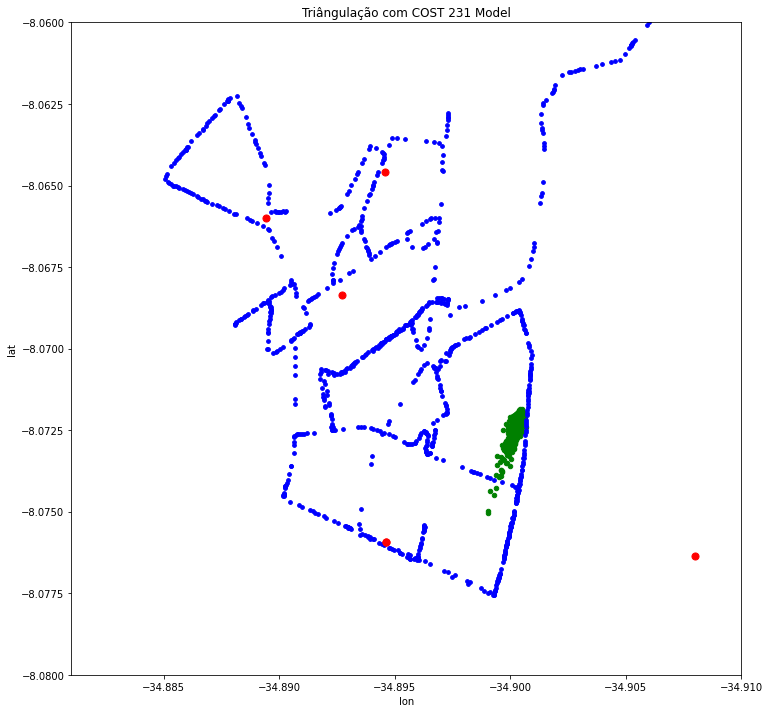

In [100]:
fig, ax = plt.subplots()
ax.scatter(merge['lon_pred_mtd1'], merge['lat_pred_mtd1'], s = 20, color = 'green', alpha = 1)
ax.scatter(merge['lon'], merge['lat'], s = 14, color = 'blue', alpha = 1)
ax.scatter(ipt['lon'], ipt['lat'], s = 50, color = 'red', alpha = 1)
ax.set(xlabel = 'lon', ylabel = 'lat')
plt.axis([-34.881,-34.91,-8.080,-8.060])
plt.gcf().set_size_inches((12,12))
plt.title('Triângulação com COST 231 Model')
plt.show()

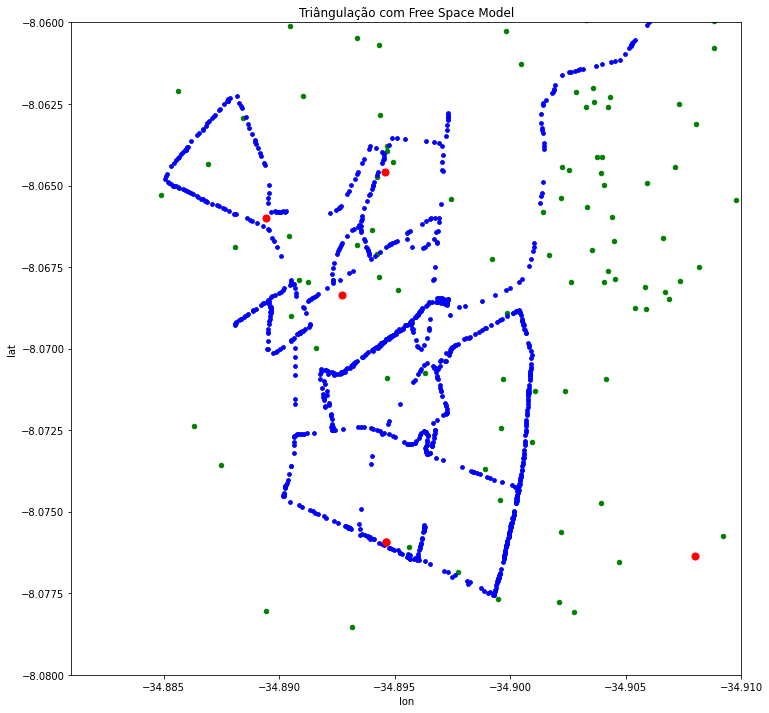

In [89]:
fig, ax = plt.subplots()
ax.scatter(merge['lon_pred_mtd2'], merge['lat_pred_mtd2'], s = 20, color = 'green', alpha = 1)
ax.scatter(merge['lon'], merge['lat'], s = 14, color = 'blue', alpha = 1)
ax.scatter(ipt['lon'], ipt['lat'], s = 50, color = 'red', alpha = 1)
ax.set(xlabel = 'lon', ylabel = 'lat')
plt.axis([-34.881,-34.91,-8.080,-8.060])
plt.gcf().set_size_inches((12,12))
plt.title('Triângulação com Free Space Model')
plt.show()

In [90]:
distances_mtd1 = []
distances_mtd2 = []
for idx, point in merge.iterrows():
  d1 = get_dist(point['lat'], point['lon'], point['lat_pred_mtd1'], point['lon_pred_mtd1'])
  d2 = get_dist(point['lat'], point['lon'], point['lat_pred_mtd2'], point['lon_pred_mtd2'])
  distances_mtd1.append(d1)
  distances_mtd2.append(d2)

In [91]:
distances_mtd1 = np.array(distances_mtd1)
distances_mtd2 = np.array(distances_mtd2)

Histograma

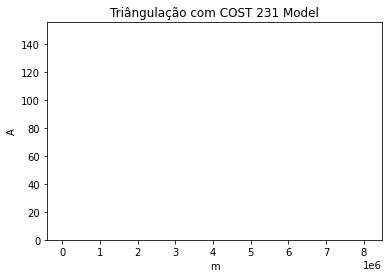

In [92]:
plt.title("Triângulação com COST 231 Model")
histogram = plt.hist(distances_mtd1.astype(int), bins='auto')
plt.xlabel('m')
plt.ylabel('A')
plt.show()

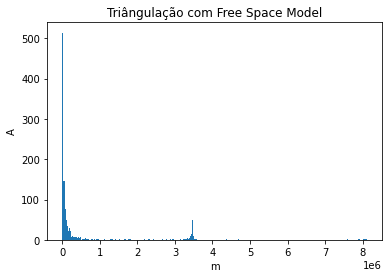

In [93]:
plt.title("Triângulação com Free Space Model")
histogram = plt.hist(distances_mtd2.astype(int), bins='auto')
plt.xlabel('m')
plt.ylabel('A')
plt.show()

Box Plot

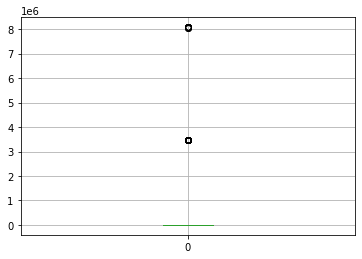

In [94]:
pd.DataFrame(data=distances_mtd1).boxplot()

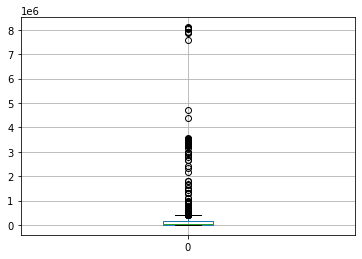

In [95]:
pd.DataFrame(data=distances_mtd2).boxplot()

Error máx, mín, médio e desvio

In [96]:
pd.DataFrame(data=distances_mtd1).describe()

,0
count,1.106000e+03
mean,4.012803e+05
std,1.236813e+06
min,3.024950e+01
25%,4.875478e+02
50%,8.604003e+02
75%,1.222266e+03
max,8.078946e+06


In [97]:
pd.DataFrame(data=distances_mtd2).describe()

,0
count,1.106000e+03
mean,4.955202e+05
std,1.224937e+06
min,8.871654e+01
25%,6.629253e+03
50%,3.560981e+04
75%,1.609826e+05
max,8.107910e+06
